In [2]:
pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set path to google drive
path ="/content/drive/MyDrive/Colab Notebooks/Group_Project_2/ETH_USD_data.csv"


In [6]:
# Read CSV file
data = pd.read_csv(path)

In [8]:
# To see data
data.head()

,Date,ETH
0,8/20/17,298.40
1,8/21/17,319.31
2,8/22/17,312.22
3,8/23/17,315.61
4,8/24/17,323.84


In [9]:
# Prep. data frame
data.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,ETH
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


In [10]:
# Slicing the date range
eth_df = data.loc['2020-03-02':'2021-05-03']
eth_df.head()

,ETH
Date,
2020-03-02,231.93
2020-03-03,223.46
2020-03-04,224.52
2020-03-05,228.81
2020-03-06,245.52


In [11]:
# Rename the column name
df_1=eth_df.rename(columns={"ETH": "Close"})
df_1.head()

,Close
Date,
2020-03-02,231.93
2020-03-03,223.46
2020-03-04,224.52
2020-03-05,228.81
2020-03-06,245.52


In [12]:
# Reset index
df = df_1.reset_index()
df.head()

,Date,Close
0,2020-03-02,231.93
1,2020-03-03,223.46
2,2020-03-04,224.52
3,2020-03-05,228.81
4,2020-03-06,245.52


In [13]:
# Add exponential and rolling moving averages
df['EMA_5'] = df['Close'].ewm(5).mean().shift()
df['EMA_10'] = df['Close'].ewm(10).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()


In [15]:
# Set definition to calcluate RSI
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

In [16]:
# Add MACD (Moving Average Convergence Divergence)
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-02,231.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,223.46,231.930000,231.930000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2020-03-04,224.52,227.310000,227.493333,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2020-03-05,228.81,226.206264,226.406405,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2020-03-06,245.52,227.044426,227.095736,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
423,2021-04-29,2758.06,2451.435705,2333.642991,2498.618,2411.847,2400.012000,2233.172000,59.164947,166.750737,134.855382
424,2021-04-30,2777.11,2502.539754,2372.226355,2606.764,2471.276,2425.245333,2263.703333,64.137459,177.546412,143.393588
425,2021-05-01,2947.57,2548.301462,2409.033959,2697.824,2515.616,2442.562667,2292.343333,74.202291,197.579191,154.230709
426,2021-05-02,2951.78,2614.846218,2457.991781,2780.400,2574.560,2477.321333,2325.001667,78.847841,211.358613,165.656290


In [17]:
# split stock data frame into three subsets: training ( 95% ), validation ( 2.5% ) and test ( 2.5% ) sets

test_size  = 0.025
valid_size = 0.025

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

train_df.tail()

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
402,2021-04-08,2081.00,1973.071428,1897.479418,2053.404,1994.665,1881.021333,1839.684000,72.473472,94.944074,74.805647
403,2021-04-09,2065.93,1991.059523,1914.163107,2067.948,2021.043,1914.225333,1846.624667,68.279012,94.642006,78.772919
404,2021-04-10,2134.01,2003.537936,1927.960097,2065.986,2043.424,1946.203333,1855.705333,69.895791,98.757685,82.769872
405,2021-04-11,2148.15,2025.283280,1946.691907,2071.342,2065.034,1975.179333,1865.964667,72.118785,101.984753,86.612848
406,2021-04-12,2136.77,2045.761067,1965.006279,2078.434,2083.067,2004.149333,1878.653667,67.287364,102.443057,89.778890


In [18]:
# Drop unnecessary columns

train_df = train_df.drop(columns=["Date"])
valid_df = valid_df.drop(columns=["Date"])
test_df  = test_df.drop(columns=["Date"])

train_df.head()

,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,231.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,223.46,231.930000,231.930000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,224.52,227.310000,227.493333,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,228.81,226.206264,226.406405,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,245.52,227.044426,227.095736,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [19]:
# Set X_train, y_train, X_valid, y_valid, X_test, and y_test
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_5        406 non-null    float64
 1   EMA_10       406 non-null    float64
 2   SMA_5        402 non-null    float64
 3   SMA_10       397 non-null    float64
 4   SMA_15       392 non-null    float64
 5   SMA_30       377 non-null    float64
 6   RSI          406 non-null    float64
 7   MACD         382 non-null    float64
 8   MACD_signal  374 non-null    float64
dtypes: float64(9)
memory usage: 28.7 KB


In [21]:
# set the parameters
parameters = {
# Number of boosted trees to fit
     'n_estimators': [1],  
# boosting learning rate
     'learning_rate': [0.001], 
 # Maximum tree depth for base learnes    
     'max_depth': [5],        
    'random_state': [1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False, parameters=parameters)
# objective='reg:squarederror' outputs regression with squared loss

In [22]:
# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_set=[(           EMA_5       EMA_10     SMA_5  ...        RSI        MACD  MACD_signal
0            NaN          NaN       NaN  ...        NaN         NaN          NaN
1     231.930000   231.930000       NaN  ...   0.000000         NaN          NaN
2     227.310000   227.493333       NaN  ...   0.000000         NaN          NaN
3     226.206264   226.406405       NaN  ...   0.000000         NaN          NaN
4     227.044426   227.095736       NaN  ...   0.000000         NaN          NaN
..           ...          ...       ...  .....
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror',
             parameters={'learning_rate': [0.001], 'max_depth': [5],
            

In [23]:
# Run predict
y_pred = model.predict(X_test)

In [24]:
# define model evaluation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=1)
# evaluate model to calculate mean absolute error
scores = cross_val_score(model, X_test, y_pred, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# Calculate R2 (mean_square_error) to evaluate predictions
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

Mean MAE: 17.434 (16.247)
mean_squared_error = 613234.5156766347


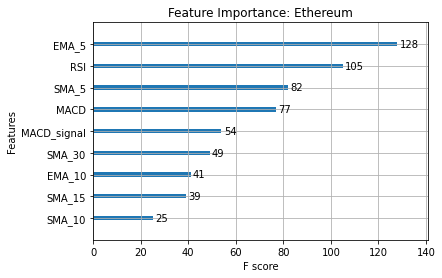

In [26]:
# Plot feature importance
plot_importance(model, title ='Feature Importance: Ethereum');

In [29]:
# Prep to create a dataframe for the predicted value and actual closing price
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
predicted_prices.Date
date_pred=pd.DataFrame(predicted_prices.Date)
date_pred=date_pred.reset_index(drop=True)
# Make the predicted value to DataFrame
amazon_pred = pd.DataFrame(y_pred)
# Make X_test value to DataFrame
actual=pd.DataFrame(y_test) 
actual_f=actual.reset_index(drop=True)
actual_f
# Combine date, closing price and predict value
actual_pred = pd.concat([date_pred, actual_f, amazon_pred], axis=1)

# Set the column name for the Predicted value
actual_pred.rename( columns={0 :'Pred'}, inplace=True )
# Calculate the difference and squar of diff.
actual_pred['Diff'] = actual_pred['Close'] - actual_pred['Pred']
actual_pred['Square'] = actual_pred['Diff']**2
actual_pred

,Date,Close,Pred,Diff,Square
0,2021-04-24,2217.33,1953.425415,263.904585,6.964563e+04
1,2021-04-25,2321.81,1960.093872,361.716128,1.308386e+05
2,2021-04-26,2534.69,2013.672974,521.017026,2.714587e+05
3,2021-04-27,2668.89,2015.191895,653.698105,4.273212e+05
4,2021-04-28,2750.37,2010.382568,739.987432,5.475814e+05
5,2021-04-29,2758.06,1965.434326,792.625674,6.282555e+05
6,2021-04-30,2777.11,2018.161987,758.948013,5.760021e+05
7,2021-05-01,2947.57,2058.338379,889.231621,7.907329e+05
8,2021-05-02,2951.78,2056.050293,895.729707,8.023317e+05
9,2021-05-03,3430.16,2056.050293,1374.109707,1.888177e+06


In [31]:
# calculate the total of diffeences
column_sum = actual_pred['Diff'].sum()
print(f"Total differences {column_sum}")
# calculate the mean squared error
MSE = actual_pred['Square'].mean()
print(f"Mean Squared Error {MSE}")
# Compute the root-mean-square
rms = np.sqrt(MSE)
print(f"Root Mean Square {rms}")
# calculate the mean of the closing prices
ClosingPrice = actual_pred['Close'].mean()
print(f"Mean Closing Price {ClosingPrice}")

Total differences 7250.967998046875
Mean Squared Error 613234.5156766347
Root Mean Square 783.0929163749565
Mean Closing Price 2735.7769999999996


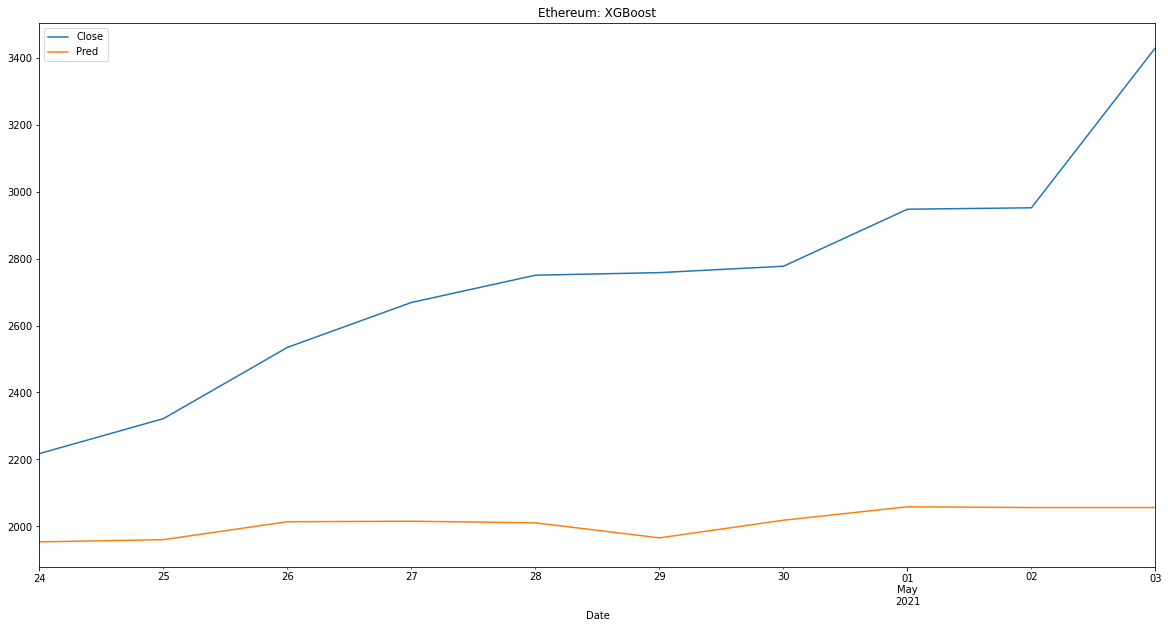

In [34]:
# Plot the closing price and predicted price
actual_pred.plot.line(x="Date", y=["Close", "Pred"],title="Ethereum: XGBoost", figsize=(20,10));

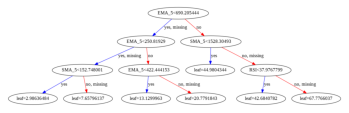

In [35]:
# plot tree
plot_tree(model, num_trees=10);